In [44]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import urllib
import gzip
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
num_epochs = 25
learning_rate = 0.001


# Data hyperparameters
batch_size = 64

# Data details

train_size = 60000
test_size = 10000
data_rows = 28
data_cols = 28
data_classes = 10

In [47]:
file_train_data = gzip.open('train-set-images.gz', 'r')
file_train_data.read(16)
buffer_train_data = file_train_data.read(train_size * data_rows * data_cols)
train_data = np.frombuffer(buffer_train_data, dtype=np.uint8).astype(np.int32)
train_data = train_data.reshape(train_size, 1, data_rows, data_cols)

file_train_labels = gzip.open('train-set-labels.gz', 'r')
file_train_labels.read(8)
buffer_train_labels = file_train_labels.read(train_size)
train_labels = np.frombuffer(buffer_train_labels, dtype=np.uint8).astype(np.int32)

file_test_data = gzip.open('test-set-images.gz', 'r')
file_test_data.read(16)
buffer_test_data = file_test_data.read(test_size * data_rows * data_cols)
test_data = np.frombuffer(buffer_test_data, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(test_size, 1, data_rows, data_cols)

file_test_labels = gzip.open('test-set-labels.gz', 'r')
file_test_labels.read(8)
buffer_test_labels = file_test_labels.read(test_size)
test_labels = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int32)

In [48]:
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size=0.1)
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)
valid_data = torch.Tensor(valid_data)
valid_labels = torch.Tensor(valid_labels)
test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

train = torch.utils.data.TensorDataset(train_data, train_labels)
test = torch.utils.data.TensorDataset(test_data, test_labels)
valid = torch.utils.data.TensorDataset(valid_data, valid_labels)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)

In [53]:
class Q2Model(nn.Module):
    def __init__(self, data_classes):
        super(Q2Model, self).__init__()

        self.cnn_layers = nn.ModuleList([
            nn.Conv2d(1, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4,4, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ])

        self.linear_layers = nn.ModuleList([
            nn.Flatten(),
            nn.Linear(4 * 7 * 7, data_classes),
            nn.Softmax(dim=1)
        ])

    def forward(self, x):
        y = x

        for layer in self.cnn_layers:
            y = layer(y)

        for layer in self.linear_layers:
            y = layer(y)
        return y

In [54]:
def train_model(model, optimizer, criterion, device, train_loader, test_loader, valid_loader, epochs):
    model = model.to(device)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss = 0
        n = 0
        tq = tqdm(train_loader)
        tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch, 0))
        model.train()
        for i, data in enumerate(tq):
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)
            optimizer.zero_grad()
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch)
            n += len(batch)
            tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch,train_loss / n,))
        train_losses.append(train_loss / n)
        
        model.eval()
        train_len = 0
        train_correct = 0
        train_loss = 0
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels.long())
            train_loss += loss.item() * len(batch)
            train_len += len(labels)
            train_correct += (predicted == labels).sum().item()

        valid_loss = 0
        valid_len = 0
        valid_correct = 0
        model.eval()
        for batch, labels in valid_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels.long())
            valid_loss += loss.item() * len(batch)
            _, predicted = torch.max(outputs.data, 1)
            valid_len += len(labels)
            valid_correct += (predicted == labels).sum().item()
        valid_losses.append(valid_loss / valid_len)
        time.sleep(0.1)
    print('Valid Accuracy: ', valid_correct / valid_len * 100)
    print('Train Accuracy: ', train_correct / train_len * 100)

    test_predictions = []
    for batch, labels in test_loader:
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions += list(predicted.data.numpy())
    return train_losses, valid_losses, test_predictions


In [55]:
def q2():
    model = Q2Model(data_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_losses, valid_losses, test_predictions = train_model(model, optimizer, criterion, device, train_loader,
                                                               test_loader, valid_loader, num_epochs)
    print('Test Accuracy: ', np.sum(np.array(test_predictions) == test_labels.numpy()) / len(test_predictions) * 100)
    epochs_list = list(range(num_epochs))
    plt.plot(epochs_list, train_losses, label='Training Loss')
    plt.plot(epochs_list, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss (Cross Entropy)')
    plt.legend()
    plt.show()

Epoch 9, Average Train Loss: 1.577251: 100%|█| 844/844 [00:06<00:00, 134.42it/s]
Epoch 10, Average Train Loss: 1.575658: 100%|█| 844/844 [00:06<00:00, 133.24it/s
Epoch 11, Average Train Loss: 1.574299: 100%|█| 844/844 [00:06<00:00, 134.08it/s
Epoch 12, Average Train Loss: 1.573053: 100%|█| 844/844 [00:06<00:00, 133.96it/s
Epoch 13, Average Train Loss: 1.572065: 100%|█| 844/844 [00:06<00:00, 132.29it/s
Epoch 14, Average Train Loss: 1.571191: 100%|█| 844/844 [00:06<00:00, 134.65it/s
Epoch 15, Average Train Loss: 1.570119: 100%|█| 844/844 [00:06<00:00, 131.91it/s
Epoch 16, Average Train Loss: 1.569259: 100%|█| 844/844 [00:06<00:00, 140.50it/s
Epoch 17, Average Train Loss: 1.568463: 100%|█| 844/844 [00:06<00:00, 137.08it/s
Epoch 18, Average Train Loss: 1.567743: 100%|█| 844/844 [00:06<00:00, 134.69it/s
Epoch 19, Average Train Loss: 1.567321: 100%|█| 844/844 [00:06<00:00, 138.89it/s
Epoch 20, Average Train Loss: 1.566779: 100%|█| 844/844 [00:06<00:00, 134.81it/s
Epoch 21, Average Train Loss

Valid Accuracy:  86.76666666666667
Train Accuracy:  88.27592592592592
Test Accuracy:  86.53


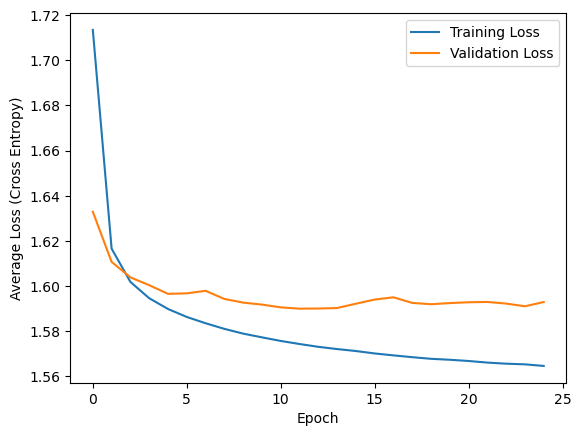

In [56]:
q2()